### Detect cloud bands between 29 March and 1 April 2002 using ERA5 3 hourly olr data, and create maps showing the evolution of the cloud bands. This study is based on Knipertz (2005)

Knippertz, P., 2005: Tropical–Extratropical Interactions Associated with an Atlantic Tropical Plume and Subtropical Jet Streak. Mon. Wea. Rev., 133, 2759–2776, https://doi.org/10.1175/MWR2999.1

In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.util as cutil
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

warnings.filterwarnings("ignore")

from cloudbandpy.load_driver import run_load_data
from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.io_utilities import load_ymlfile, add_startend_datetime2config, get_variable_lonlat_from_domain
from cloudbandpy.figure_tools import set_fontsize

Load configuration file and make adjustements for this test case

In [2]:
config_file = "../config/config_cbworkflow_northernhemisphere.yml"
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Changing configs to adapt to this particular example
config_event["startdate"] = "20020329.00"
config_event["enddate"] = "20020401.00"
# update datetime dates from config file
add_startend_datetime2config(config_event)
dirdata = "../data/"
config_event["clouddata_path"] = os.path.join("../data")
config_event["parameters_file"] = os.path.join("../parameters/parameters_northhemisphere.yml")
# No need to save any files
config_event["saved_dirpath"] = ""
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

2023-05-15 12:52:16,458 - io_utilities.load_ymlfile - INFO: Configuration file loaded


Load ERA5 data and get its resolution, and load parameters file. The ERA5 file contains OLR data from 01.01.2016 to 30.05.2016.

In [3]:
olr2process, parameters, listofdates, lats_in, lons_in, resolution = run_load_data(config_event)
config_event["lat_south"] = 0
lat_north = config_event["lat_north"]
lat_south = config_event["lat_south"]
lon_west = config_event["lon_west"]
lon_east = config_event["lon_east"]
olr, lons, lats = get_variable_lonlat_from_domain(
    olr2process, lons_in, lats_in, lon_west, lon_east, lat_north, lat_south
)
# add cyclic
cyc_olr, clons = cutil.add_cyclic_point(olr, lons)

2023-05-15 12:52:16,475 - load_driver.run_load_data - INFO: Loading data and parameters 
2023-05-15 12:52:16,478 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2023-05-15 12:52:16,480 - io_utilities.load_dataset - INFO: Loading dataset from ../data
2023-05-15 12:52:16,481 - io_utilities.load_dataset - INFO: Loading 2002 --> 2002
2023-05-15 12:52:17,289 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2023-05-15 12:52:17,299 - io_utilities.make_daily_average - INFO: Computation of daily average
2023-05-15 12:52:17,341 - io_utilities.make_daily_average - INFO: Computation of daily average done
2023-05-15 12:52:17,345 - io_utilities.load_dataset - INFO: Dataset loaded
2023-05-15 12:52:17,371 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done


Map of OLR data. Horizontal lines are the lines that define cloud bands. Yellow contours are the 210 W/m2 OLR threshold.


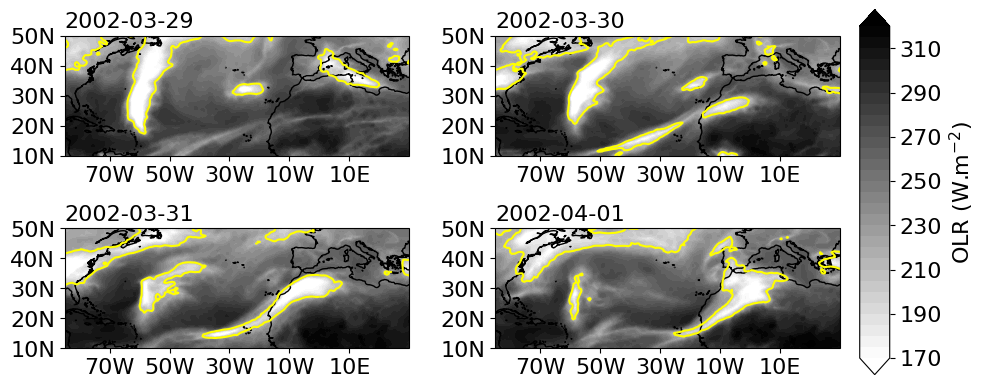

In [4]:
set_fontsize(16)
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")

fig, axs = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)}, figsize=(10, 5)
)
for idx, axs in enumerate(axs.ravel()):
    fill = axs.contourf(clons, lats, cyc_olr[idx], cmap="binary", levels=range(170, 325, 5), extend="both")
    axs.contour(clons, lats, cyc_olr[idx], colors="yellow", levels=[210])
    axs.coastlines()
    lonticks = np.arange(-90, 30, 20)
    latticks = np.arange(0, 60, 10)
    axs.set_xticks(lonticks, crs=ccrs.PlateCarree())
    axs.set_yticks(latticks, crs=ccrs.PlateCarree())
    axs.xaxis.set_major_formatter(LON_FORMAT)
    axs.yaxis.set_major_formatter(LAT_FORMAT)
    axs.set_extent([-85, 30, 33, 0])
    axs.set_ylim([10, 50])
    axs.set_title(f"{listofdates[idx].strftime('%Y-%m-%d')}", loc="left")

cbar_ax = fig.add_axes([0.92, 0.13, 0.03, 0.73])
cbar = fig.colorbar(fill, cax=cbar_ax)
cbar.set_label(r"OLR (W.m$^{-2}$)")
fig.subplots_adjust(wspace=0.25, hspace=0)
fig.show()

Run cloud band detection for each day

In [5]:
(
    _,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_over_time,
    list_of_cloudbands,
) = detection_workflow(
    var2process=cyc_olr,
    parameters=parameters,
    latitudes=lats,
    longitudes=clons,
    resolution=resolution,
    listofdates=listofdates,
    config=config_event,
)

2023-05-15 12:52:22,170 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-05-15 12:52:22,171 - cb_detection.detection_workflow - INFO: Blobs that are longitudinally crossing the map will be connected
2023-05-15 12:52:22,274 - cb_detection.detection_workflow - INFO: Cloud band detection done


Figure of cloud bands (shading) and of labelled cloud band candidates (contour). Lines show where the cloud bands must cross to be defined as a cloud band.

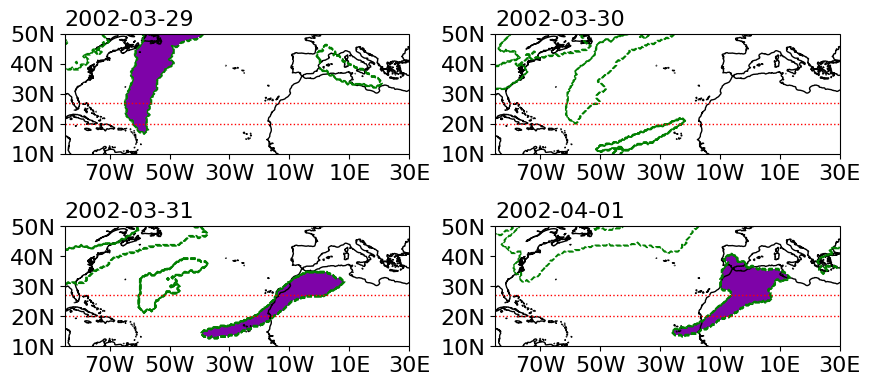

In [6]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)}, figsize=(10, 5)
)
for idx, axs in enumerate(axs.ravel()):
    fill = axs.contourf(
        clons, lats, np.ma.masked_where(cloud_bands_over_time[idx] == 0, cloud_bands_over_time[idx]), cmap="plasma"
    )
    axs.contour(clons, lats, labelled_candidates[idx], colors="g", linestyles="--", linewidths=1)
    lonticks = np.arange(-90, 40, 20)
    latticks = np.arange(0, 60, 10)
    axs.set_xticks(lonticks, crs=ccrs.PlateCarree())
    axs.set_yticks(latticks, crs=ccrs.PlateCarree())
    axs.xaxis.set_major_formatter(LON_FORMAT)
    axs.yaxis.set_major_formatter(LAT_FORMAT)
    axs.coastlines()
    axs.set_extent([-85, 30, 33, 0])
    axs.set_ylim([10, 50])
    axs.set_title(f"{listofdates[idx].strftime('%Y-%m-%d')}", loc="left")
    gl2 = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl2.ylocator = mticker.FixedLocator([0, 27])
    gl2.xlines = False
    gl3 = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl3.ylocator = mticker.FixedLocator([0, 20])
    gl3.xlines = False

fig.subplots_adjust(wspace=0.25, hspace=0.0)
fig.show()

No, we change the OLR threshold to 240 W/m2 for the detection in order to get the same cloud band as in Knipertz (2005).

In [7]:
parameters["OLR_THRESHOLD"] = 240
(
    _,
    dilation,
    labelled_blobs,
    labelled_candidates,
    cloud_bands_over_time,
    list_of_cloudbands,
) = detection_workflow(
    var2process=cyc_olr,
    parameters=parameters,
    latitudes=lats,
    longitudes=clons,
    resolution=resolution,
    listofdates=listofdates,
    config=config_event,
)

2023-05-15 12:52:22,726 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-05-15 12:52:22,727 - cb_detection.detection_workflow - INFO: Blobs that are longitudinally crossing the map will be connected
2023-05-15 12:52:22,857 - cb_detection.detection_workflow - INFO: Cloud band detection done


Figure of  the mean of all the labelled cloud band candidates overlayed by the contour of the mean of cloud band. Lines show where the cloud bands must cross to be defined as a cloud band.

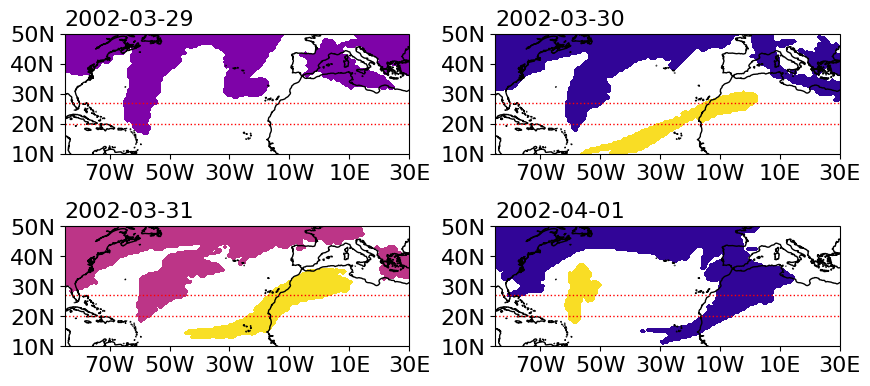

In [8]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)}, figsize=(10, 5)
)
for idx, axs in enumerate(axs.ravel()):
    fill = axs.contourf(
        clons, lats, np.ma.masked_where(cloud_bands_over_time[idx] == 0, cloud_bands_over_time[idx]), cmap="plasma"
    )
    lonticks = np.arange(-90, 40, 20)
    latticks = np.arange(0, 60, 10)
    axs.set_xticks(lonticks, crs=ccrs.PlateCarree())
    axs.set_yticks(latticks, crs=ccrs.PlateCarree())
    axs.xaxis.set_major_formatter(LON_FORMAT)
    axs.yaxis.set_major_formatter(LAT_FORMAT)
    axs.coastlines()
    axs.set_extent([-85, 30, 33, 0])
    axs.set_ylim([10, 50])
    axs.set_title(f"{listofdates[idx].strftime('%Y-%m-%d')}", loc="left")
    gl2 = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl2.ylocator = mticker.FixedLocator([0, 27])
    gl2.xlines = False
    gl3 = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color="r", linestyle=":")
    gl3.ylocator = mticker.FixedLocator([0, 20])
    gl3.xlines = False

fig.subplots_adjust(wspace=0.25, hspace=0.0)
fig.show()